In [2]:
pwd()
include("ConfigLoader.jl")

parse_config (generic function with 1 method)

In [3]:
include("ConfigLoader.jl")

include("solvers.jl")
include("diagnostics.jl")
using .Solvers

@show varinfo(Solvers)
config_path = "../config.toml"
conf = parse_config(config_path)
prob = Solvers.LinearAdvectionProblem(conf[1])

varinfo(Solvers) = | name                   |        size | summary                                                 |
|:---------------------- | -----------:|:------------------------------------------------------- |
| MOL_RK4_advection      |     0 bytes | MOL_RK4_advection (generic function with 1 method)      |
| Solvers                | 596.883 KiB | Module                                                  |
| donor_cell_advection   |     0 bytes | donor_cell_advection (generic function with 1 method)   |
| lax_wendroff_advection |     0 bytes | lax_wendroff_advection (generic function with 1 method) |
| leap_frog_RA_advection |     0 bytes | leap_frog_RA_advection (generic function with 1 method) |
| van_leer_advection     |     0 bytes | van_leer_advection (generic function with 1 method)     |



Main.Solvers.LinearAdvectionProblem("problem02", 0.5, 0.5, (1.0, 100.0), AbstractFloat[1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5  …  95.5, 96.0, 96.5, 97.0, 97.5, 98.0, 98.5, 99.0, 99.5, 100.0], 198, 0.1, 0.1, 10.0, 100, var"#14#15"(), :periodic, 2.0, 0.4)

In [15]:
using Plots

In [4]:
using Dates
using Plots

"""
    simulate_advection(prob::Solvers.LinearAdvectionProblem, gamma::T) where {T<:AbstractFloat}

Simulates the linear advection equation using multiple numerical methods and returns diagnostics and solutions.

# Arguments
- `prob::Solvers.LinearAdvectionProblem`: 
    A problem definition that contains the initial condition, advection speed, grid setup, time step size, and number of time steps.
- `gamma::T`:
    The Robert–Asselin filter parameter used in the Leap-Frog scheme. Must be a subtype of `AbstractFloat`.

# Returns
- `diagnostics::Dict{String, Float64}`: 
    A dictionary containing diagnostic metrics for each method and variable, including:
    - `"u_<scheme>_rmse"`: Root mean square error compared to the exact solution.
    - `"u_<scheme>_rm"`: Root mean.
    - `"u_<scheme>_rmp"`: Root mean of positive values.
    - `"u_<scheme>_mdr"`: Mean deviation ratio.
    - `"u_<scheme>_rmax"`: Relative max.
    - `"u_<scheme>_rmin"`: Relative min.
- `solutions::Dict{String, Matrix{Float64}}`:
    A dictionary mapping scheme names (`"donor_cell"`, `"leap_frog"`, `"lax_wendroff"`, `"van_leer"`, `"rk4"`) to their numerical solution arrays.

# Description
The function:
- Computes the exact solution of the linear advection equation.
- Solves the problem using five numerical schemes:
    - Donor Cell
    - Leap-Frog with Robert–Asselin filter
    - Lax–Wendroff
    - Van Leer
    - Method of Lines with RK4
- Measures performance (computation time and memory) for each scheme.
- Computes diagnostic metrics comparing each scheme to the exact or self-referential statistics.
- Logs the status of each step using `@info`.

# Example
```julia
prob = Solvers.LinearAdvectionProblem("test", ... )
gamma = 0.1
diagnostics, solutions = simulate_advection(prob, gamma)

# See Also

Solvers.donor_cell_advection, Solvers.leap_frog_RA_advection, Solvers.lax_wendroff_advection, Solvers.van_leer_advection, Solvers.MOL_RK4_advection

"""
function simulate_advection(prob::Solvers.LinearAdvectionProblem, gamma::T) where {T<:AbstractFloat}

       #  gamma constant for Robert Asselin Filter
    diagnostics = Dict() # initialise empty dictionary 

    @info "$(now()) - Start Simulation of Problem $(prob.name)"
    @info "$(now()) - Compute exact solution"
    # compute exact solution and cell centers and time
    cell_centers = prob.grid_cell_boundary[1:end-1] + diff(prob.grid_cell_boundary) * 0.5
    t = collect(range(0; step=prob.dt, length=prob.time_steps))
    exact_sol(x,t) = prob.initial(x - prob.advection_speed * t)    # exact solution as function   
    u_exact = exact_sol.(cell_centers, t')                         # exact solution as array

    # compute numerical schemes
    @info "$(now()) - Compute numerical approximation"
    u_donor_cell, comp_time, mem_allocated =  @timed Solvers.donor_cell_advection(prob)
    @info "$(now()) - Donor cell method done!\n  computation time: $(comp_time * 1000) ms\n  allocated memory: $(mem_allocated / 1000) kB"
    u_leap_frog, comp_time, mem_allocated = @timed Solvers.leap_frog_RA_advection(prob, gamma)
    @info "$(now()) - Leap frog method with Robert Asselin Filter done!\n  computation time: $(comp_time * 1000) ms\n  allocated memory: $(mem_allocated / 1000) kB"
    u_laxwendroff, comp_time, mem_allocated = @timed Solvers.lax_wendroff_advection(prob)
    @info "$(now()) - Lax Wendroff method done!\n  computation time: $(comp_time * 1000) ms\n  allocated memory: $(mem_allocated / 1000) kB"
    u_vanleer, comp_time, mem_allocated = @timed Solvers.van_leer_advection(prob)
    @info "$(now()) - Van Leer method done!\n  computation time: $(comp_time + 1000) ms\n  allocated memory: $(mem_allocated / 1000) kB"
    u_rk4, comp_time, mem_allocated = @timed Solvers.MOL_RK4_advection(prob)
    @info "$(now()) - Method of Lines done!\n  computation time: $(comp_time * 1000) ms\n  allocated memory: $(mem_allocated / 1000) kB"

    numerical_approximations = zip(["donor_cell", "leap_frog", "lax_wendroff", "van_leer", "rk4"], [u_donor_cell, u_leap_frog, u_laxwendroff, u_vanleer, u_rk4])
    for (scheme, approx) in numerical_approximations
        for (diag_name, diag) in zip(["rmse", "rm", "rmp", "mdr", "rmax", "rmin"], [diagnostic_rmse, diagnostic_rm, diagnostic_rmp, diagnostic_mdr, diagnostic_rmax, diagnostic_rmin])
            key = "u_" * scheme * "_" * diag_name
            if diag_name == "rmse"
                val = diag(u_exact, approx)
            else
                val = diag(approx)
            end
            diagnostics[key] = val
        end
    end
    @info "$(now()) - Computation of diagnostics done!"

    return diagnostics, Dict(numerical_approximations)
end

function generate_plot_simulation(;idx::Vector{<:Integer}, title::String, cell_centers::Vector{T}, u_approx::AbstractMatrix{T}) where {T<:AbstractFloat}
    plt = plot(
        xlabel = "x",
        ylabel = "u(t,x",
        title=title,
        legend=:topright)
    for i in idx
        plot!(cell_centers, u_approx[:, i], label = "n = $i")
    end

    return plt
end
function post_process(diagnostics::Dict, numerical_approximations::Dict, indices::Vector{T}, path_images::String, path_table::String, prob::Solvers.LinearAdvectionProblem) where {T<:Integer}
    idx = [i for i in indices if i < prob.time_steps]
    cell_centers = prob.grid_cell_boundary[1:end-1] + diff(prob.grid_cell_boundary) * 0.5
    @info "Start post processing"
    
    # generate plots for the simulation
    plt_donor_cell = generate_plot_simulation(idx=idx,     # indices to plot
        title = "Simulation with the Donor Cell Scheme",
        cell_centers = cell_centers,
        u_approx =  numerical_approximations["donor_cell"])
    filename = path_images * "/simulation-donorcell.png"
    savefig(plt_donor_cell, filename)
    @info "$(now()) - Simulation image saved to $(filename)"

    plt_leap_frog = generate_plot_simulation(idx=idx,
        title = "Simulation with the Leap Frog Scheme",
        cell_centers = cell_centers,
        u_approx = numerical_approximations["leap_frog"])
    filename = path_images * "/simulation-leapfrog.png"
    savefig(plt_leap_frog, filename)
    @info "$(now()) - Simulation image saved to $(filename)"

    plt_laxwendroff = generate_plot_simulation(idx=idx,
        title = "Simulation with the Lax Wendroff Scheme",
        cell_centers = cell_centers,
        u_approx = numerical_approximations["lax_wendroff"])
    filename =  path_images * "/simulation-laxwendroff.png"
    savefig(plt_laxwendroff, filename)
    @info "$(now()) - Simulation image saved to $(filename)"

    plt_van_leer = generate_plot_simulation(idx=idx,
        title = "Simulation with the Van Leer Scheme",
        cell_centers = cell_centers,
        u_approx = numerical_approximations["van_leer"])
    filename = path_images * "/simulation-vanleer.png"
    savefig(plt_van_leer, filename)
    @info "$(now()) - Simulation image saved to $(filename)"

    plt_rk4 = generate_plot_simulation(idx=idx,
        title = "Simulation with the RK4 Method",
        cell_centers = cell_centers,
        u_approx = numerical_approximations["rk4"])
    filename = path_images * "/simulation-rk4.png"
    savefig(plt_rk4, filename)
    @info "$(now()) - Simulation image saved to $(filename)"

    # plot diagnostics
    plt_rmse = plot_diagnostic(diagnostic_name="rmse",
        title="RMSE for Different Schemes",
        label_yaxis="RMSE",
        prob=prob)
    filename = path_images * "/" * prob.name * "-RMSE.png"
    savefig(plt_rmse, filename)
    @info "$(now()) - Plot RMSE saved to $(filename)"

    plt_rm = plot_diagnostic(diagnostic_name="rm",
        title="RM for Different Schemes",
        label_yaxis="RM",
        prob=prob)
    filename = path_images * "/" * prob.name * "-RM.png"
    savefig(plt_rm, filename)
    @info "$(now()) - Plot RM saved to $(filename)"

    plt_rmp = plot_diagnostic(diagnostic_name="rmp",
        title="RMP for Different Schemes",
        label_yaxis="RMP",
        prob=prob)
    filename = path_images * "/" * prob.name * "-RMP.png"
    savefig(plt_rmp, filename)
    @info "$(now()) - Plot RMP saved to $(filename)"

    plt_mdr = plot_diagnostic(diagnostic_name="mdr",
        title="MDR for Different Schemes",
        label_yaxis="MDR",
        prob=prob)
    filename = path_images * "/" * prob.name * "-MDR.png"
    savefig(plt_mdr, filename)
    @info "$(now()) - Plot MDR saved to $(filename)"

    plt_rmax = plot_diagnostic(diagnostic_name="rmax",
        title="RMAX for Different Schemes",
        label_yaxis="RMAX",
        prob=prob)
    filename = path_images * "/" * prob.name * "-RMAX.png"
    savefig(plt_rmse, filename)
    @info "$(now()) - Plot RMAX saved to $(filename)"

    plt_rmin = plot_diagnostic(diagnostic_name="rmin",
        title="RMIN for Different Schemes",
        label_yaxis="RMIN",
        prob=prob)
    filename = path_images * "/" * prob.name * "-RMIN.png"
    savefig(plt_rmse, filename)
    @info "$(now()) - Plot RMIN saved to $(filename)"
end

diag, u_approx =  simulate_advection(prob)

#post_process(diag, u_approx, [1, 5, 10, 90, 180], "./", "./test", prob)




#display(plt)

[ Info: 2025-08-02T18:44:14.721 - Start Simulation of Problem problem02
[ Info: 2025-08-02T18:44:15.694 - Compute exact solution
[ Info: 2025-08-02T18:44:16.089 - Compute numerical approximation
┌ Info: 2025-08-02T18:44:16.516 - Donor cell method done!
│   computation time: 426.087686 ms
└   allocated memory: 56186.752 kB
┌ Info: 2025-08-02T18:44:16.751 - Leap frog method with Robert Asselin Filter done!
│   computation time: 235.211663 ms
└   allocated memory: 22826.344 kB
┌ Info: 2025-08-02T18:44:17.208 - Lax Wendroff method done!
│   computation time: 456.970803 ms
└   allocated memory: 36151.08 kB
┌ Info: 2025-08-02T18:44:17.542 - Van Leer method done!
│   computation time: 1000.333398073 ms
└   allocated memory: 36076.184 kB
┌ Info: 2025-08-02T18:44:18.489 - Method of Lines done!
│   computation time: 946.780989 ms
└   allocated memory: 104810.328 kB
[ Info: 2025-08-02T18:44:19.213 - Computation of diagnostics done!


(Dict{Any, Any}("u_van_leer_rmax" => [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  0.9980798623358836, 0.9977467744587399, 0.9976739398258029, 0.9977133172964906, 0.997127748185796, 0.9973992525015067, 0.997114674987226, 0.9968714598400623, 0.9969768186826985, 0.9962341449311041], "u_rk4_rm" => [1.0, 1.0, 0.9999999999999998, 0.9999999999999998, 1.0, 1.0000000000000002, 0.9999999999999998, 0.9999999999999998, 1.0, 0.9999999999999998  …  0.9999999999999998, 1.0, 0.9999999999999998, 0.9999999999999998, 0.9999999999999997, 0.9999999999999997, 0.9999999999999998, 1.0, 0.9999999999999998, 0.9999999999999998], "u_van_leer_rmp" => [20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0  …  19.999999999999996, 19.999999999999996, 19.999999999999996, 19.999999999999996, 19.999999999999996, 20.0, 20.0, 20.0, 20.0, 19.999999999999996], "u_donor_cell_mdr" => [20.0, 19.52, 19.270400000000002, 19.085312000000002, 18.9315584, 18.797195264, 18.676351483904, 18.56562585141248, 18.46283974163

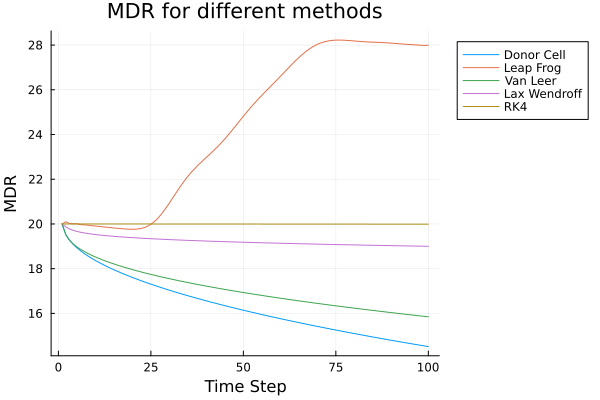

In [7]:

function titlecase(s::AbstractString)
    join(uppercasefirst.(split(s)), " ")
end


function plot_diagnostic(;diagnostic_name::String, title::String, label_yaxis::String, prob::Solvers.LinearAdvectionProblem)
    x = 1:prob.time_steps
    plt = plot(
        xlabel = "Time Step",
        ylabel = label_yaxis,
        title=title,
        legend=:outertopright)

    for key in keys(diag)
        pos = findlast(==('_'), key)
        if key[pos+1:end] == diagnostic_name
            label = replace(key[3:pos-1], "_" => " ")
            if label == "rk4"
                    label = "RK4"
            else
                label = titlecase(label)
            end
            plot!(x, diag[key], label=label)
        end
    end

    return plt
end

plt = plot_diagnostic(diagnostic_name="mdr",
                    title="MDR for different methods", 
                    label_yaxis="MDR",
                    prob=prob)
display(plt)
        

    

In [8]:
diag

Dict{Any, Any} with 30 entries:
  "u_van_leer_rmax"     => [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  ……
  "u_rk4_rm"            => [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  ……
  "u_van_leer_rmp"      => [20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.…
  "u_donor_cell_mdr"    => [20.0, 19.52, 19.2704, 19.0853, 18.9316, 18.7972, 18…
  "u_leap_frog_rmax"    => [1.0, 1.192, 1.312, 1.3632, 1.36723, 1.29917, 1.2306…
  "u_lax_wendroff_rmse" => [0.0, 0.0306166, 0.0497447, 0.0375409, 0.0639536, 0.…
  "u_van_leer_rmse"     => [0.0, 0.0402015, 0.0395939, 0.0429963, 0.0501307, 0.…
  "u_leap_frog_rmin"    => [0.0, -0.192, -0.312, -0.3632, -0.367232, -0.299174,…
  "u_donor_cell_rmp"    => [20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.…
  "u_donor_cell_rmax"   => [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  ……
  "u_van_leer_rm"       => [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  ……
  "u_van_leer_rmin"     => [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0 

In [56]:
using PrettyTables

indices = [1, 2, 5, 90 , 180]
function generate_table(;diag::Dict, indices::Vector{<:Integer}, table_path::String, title::String, latex_label::String, prob::Solvers.LinearAdvectionProblem)
    data_dc = hcat(["Donor Cell"; repeat([""], length(indices)-1)],
                indices,
                diag["u_donor_cell_rmse"][indices],
                diag["u_donor_cell_rm"][indices],
                diag["u_donor_cell_rmp"][indices],
                diag["u_donor_cell_mdr"][indices],
                diag["u_donor_cell_rmax"][indices], 
                diag["u_donor_cell_rmin"][indices])    
    data_lf = hcat( ["Leap Frog"; repeat([""], length(indices)-1)],
                indices, 
                diag["u_leap_frog_rmse"][indices],
                diag["u_leap_frog_rm"][indices],
                diag["u_leap_frog_rmp"][indices],
                diag["u_leap_frog_mdr"][indices],
                diag["u_leap_frog_rmax"][indices], 
                diag["u_leap_frog_rmin"][indices])
    data_lw = hcat(["Lax Wendroff"; repeat([""], length(indices)-1)],
                indices,
                diag["u_lax_wendroff_rmse"][indices],
                diag["u_lax_wendroff_rm"][indices],
                diag["u_lax_wendroff_rmp"][indices],
                diag["u_lax_wendroff_mdr"][indices],
                diag["u_lax_wendroff_rmax"][indices], 
                diag["u_lax_wendroff_rmin"][indices])    
    data_vl = hcat(["van Leer"; repeat([""], length(indices)-1)],
                indices,
                diag["u_van_leer_rmse"][indices],
                diag["u_van_leer_rm"][indices],
                diag["u_van_leer_rmp"][indices],
                diag["u_van_leer_mdr"][indices],
                diag["u_van_leer_rmax"][indices], 
                diag["u_van_leer_rmin"][indices])    
    data_rk4 = hcat(["RK4"; repeat([""], length(indices)-1)],
                indices,
                diag["u_rk4_rmse"][indices],
                diag["u_rk4_rm"][indices],
                diag["u_rk4_rmp"][indices],
                diag["u_rk4_mdr"][indices],
                diag["u_rk4_rmax"][indices], 
                diag["u_rk4_rmin"][indices])
    
    table_data = vcat(data_dc, data_lf, data_lw, data_vl, data_rk4)
    #title = "Diagnostics for the linear advection problem"
    column_labels =  ["Method", "time step", "RMSE", "RM", "RMP", "MDR", "RMAX", "RMIN"]
    #merge_column_label_cells = :auto
    cuts    = 1 .+ (0:5) * length(indices)     # [1, n+1, 2n+1, 3n+1, 4n+1, 5n+1]
    file_name = table_path * "/" * prob.name * "-diagnostics-table.tex"

    # write to latex file
    open(file_name, "w") do io
        pretty_table(io, table_data;
            header  = column_labels,
            title   = title,
            backend = Val(:latex),
            label   = latex_label
        )
    end
    @info "Table with diagnostics saved as $(file_name)"
# print to stdout
    pretty_table(
        table_data,
        header = column_labels,
        title = title,
        hlines = [0;cuts] # repeat([length(indices)+1], 5)],
        )
end

generate_table(diag=diag,
    indices=indices,
    table_path=".", 
    title="Diagnostics of the linear advection problem",
    latex_label="tab:01",
    prob=prob)
#pretty_table(pt, backend = Val(:latex))



[ Info: Table with diagnostics saved as ./problem02-diagnostics-table.tex


Diagnostics of the linear advection problem
┌──────────────┬───────────┬───────────┬─────────┬─────────┬─────────┬──────────┬───────────┐
│       Method │ time step │      RMSE │      RM │     RMP │     MDR │     RMAX │      RMIN │
├──────────────┼───────────┼───────────┼─────────┼─────────┼─────────┼──────────┼───────────┤
│   Donor Cell │         1 │       0.0 │     1.0 │    20.0 │    20.0 │      1.0 │       0.0 │
│              │         2 │ 0.0402015 │     1.0 │    20.0 │   19.52 │      1.0 │       0.0 │
│              │         5 │  0.052741 │     1.0 │    20.0 │ 18.9316 │      1.0 │       0.0 │
│              │        90 │  0.104983 │     1.0 │    20.0 │ 14.7967 │ 0.970042 │       0.0 │
├──────────────┼───────────┼───────────┼─────────┼─────────┼─────────┼──────────┼───────────┤
│    Leap Frog │         1 │       0.0 │     1.0 │    20.0 │    20.0 │      1.0 │       0.0 │
│              │         2 │ 0.0284722 │     1.0 │  20.192 │ 20.0965 │    1.192 │    -0.192 │
│              │